In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import glob
from astropy.table import Table
import sys
sys.path.append('..')
from util.helper import *
from util.sdtpy import *
import inspect
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value


In [2]:
snrcut = 3
source = 'MOSFiT'
fittype = 'SNIax'
verbose = True

In [97]:
snrcut = 3
source = 'MOSFiT'
fittype = 'SNIax'
verbose = True

# %%
models = sorted(glob.glob(f'../model/PLAsTiCC/{fittype}/SIMSED.{fittype}/*.fits'))
print(f"{len(models)} models found") 

# %%
path_sedinfo = f'../model/PLAsTiCC/{fittype}/SIMSED.{fittype}/SED.INFO'
infotbl = tablize_sedinfo(path_sedinfo, models)

# %%
ii = 10
model = models[ii]
_mdtbl = Table.read(model)

indx = np.where(
    (_mdtbl['col1'] <= 30) &
    (_mdtbl['col2'] >= 2000) &
    (_mdtbl['col2'] <= 11000)
)

mdtbl = _mdtbl[indx]
phasearr = np.unique(mdtbl['col1'])
lamarr = np.unique(mdtbl['col2'])
number_of_unique_phase, number_of_unique_wavelength = len(phasearr), len(lamarr)
flux2darr = mdtbl['col3'].reshape(number_of_unique_phase, number_of_unique_wavelength)
distarr = np.array([10, 1000+10, 10])
zarr = np.array([1e-3, 1e0])
print(f"Table length: {len(_mdtbl)} --> {len(mdtbl)}")

# %%
param_keys = infotbl.keys()[2:]

1001 models found
Table length: 112800 --> 25200


In [4]:
# 데이터 변환
X, y = prepare_rf_train_data(infotbl, param_keys, phasearr, number_of_unique_phase, number_of_unique_wavelength, phase_upper=np.max(phasearr), lam_lower=np.min(lamarr), lam_upper=np.max(lamarr))
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# %%
# Random Forest 모델 생성 및 훈련
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [128]:
y_pred = rf.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 평균 제곱 오차 (MSE) 계산
mse = mean_squared_error(y_test, y_pred)
print("평균 제곱 오차 (MSE):", mse)

# 평균 절대 오차 (MAE) 계산
mae = mean_absolute_error(y_test, y_pred)
print("평균 절대 오차 (MAE):", mae)

# 결정 계수 (R-squared) 계산
r2 = r2_score(y_test, y_pred)
print("결정 계수 (R-squared):", r2)


평균 제곱 오차 (MSE): 7.771376293245812e-07
평균 절대 오차 (MAE): 0.00020583428816347782
결정 계수 (R-squared): 0.9973127713225673


# Test RF model

In [133]:
param_keys

['M_V', 't_rise', 'dm15B', 'dm15R']

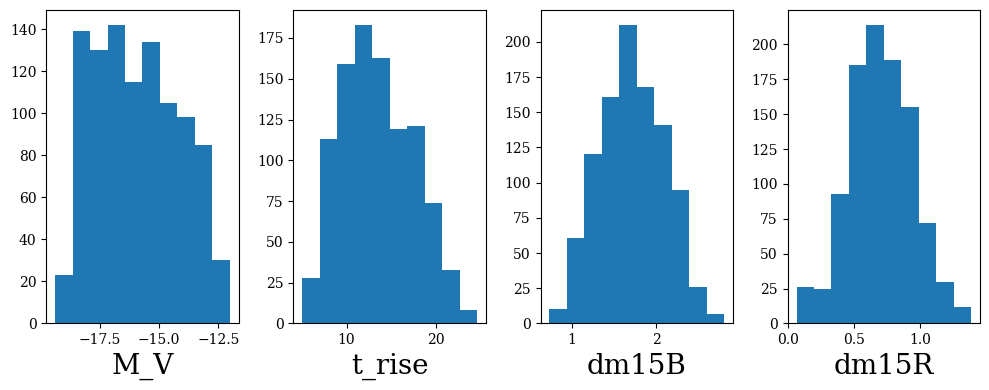

In [137]:
fig = plt.figure(figsize=(10,4))
plt.subplot(141)
key = 'M_V'
plt.hist(infotbl[key])
plt.xlabel(key)

plt.subplot(142)
key = 't_rise'
plt.hist(infotbl[key])
plt.xlabel(key)

plt.subplot(143)
key = 'dm15B'
plt.hist(infotbl[key])
plt.xlabel(key)

plt.subplot(144)
key = 'dm15R'
plt.hist(infotbl[key])
plt.xlabel(key)

plt.tight_layout()

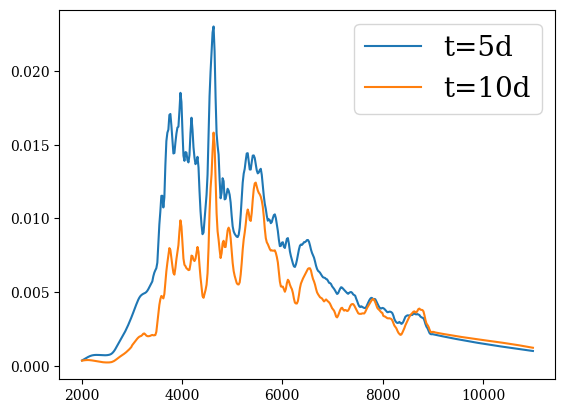

In [142]:
M_V = np.mean(infotbl['M_V'])
t_rise = np.mean(infotbl['t_rise'])
dm15B = np.mean(infotbl['dm15B'])
dm15R = np.mean(infotbl['dm15R'])

t0 = 5
t1 = 10

new_data0 = np.array(
	[[M_V, t_rise, dm15B, dm15R, t0]]
	)
#	Spectrum : wavelength & flux
flam0 = rf.predict(new_data0)[0]

new_data1 = np.array(
	[[M_V, t_rise, dm15B, dm15R, t1]]
	)
flam1 = rf.predict(new_data1)[0]

plt.plot(lamarr, flam0, label=f't={t0}d')
plt.plot(lamarr, flam1, label=f't={t1}d')

plt.legend(fontsize=20)

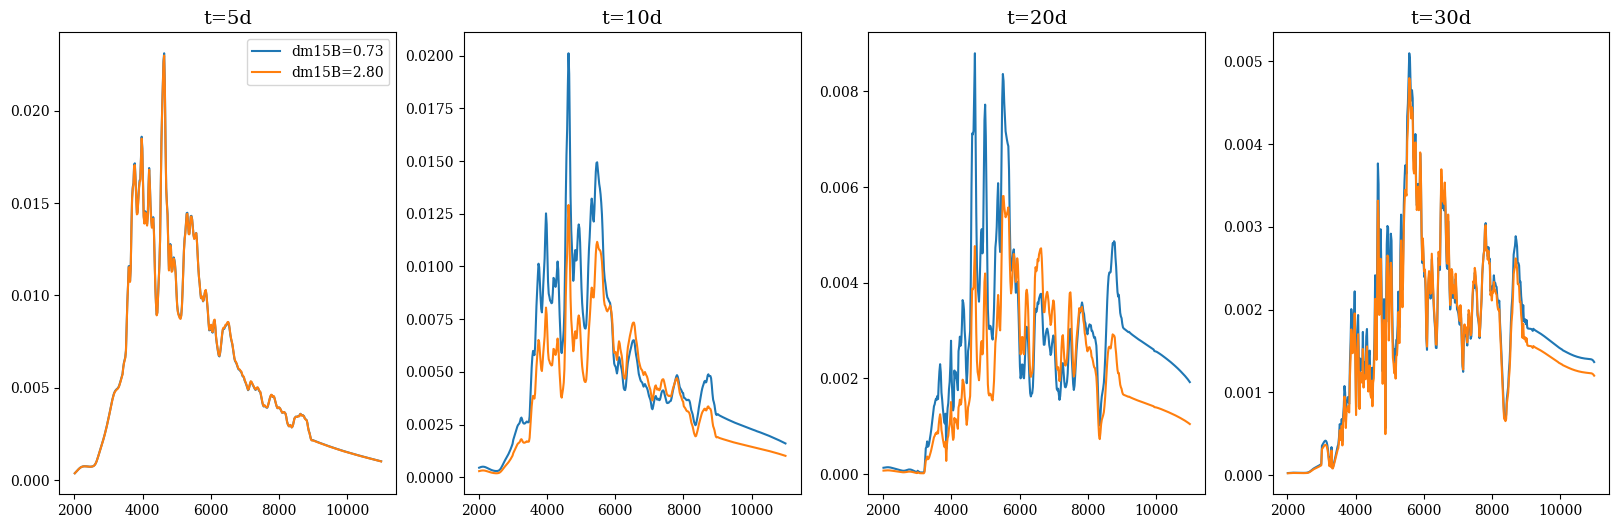

In [148]:
M_V = np.mean(infotbl['M_V'])
t_rise = np.mean(infotbl['t_rise'])
# dm15B = np.mean(infotbl['dm15B'])
dm15R = np.mean(infotbl['dm15R'])

plt.figure(figsize=(20, 6))
for tt, t in enumerate([5, 10, 20, 30]):
	plt.subplot(1, 4, tt+1)
	dm15B0 = np.min(infotbl['dm15B'])
	dm15B1 = np.max(infotbl['dm15B'])

	new_data0 = np.array(
		[[M_V, t_rise, dm15B0, dm15R, t]]
		)
	#	Spectrum : wavelength & flux
	flam0 = rf.predict(new_data0)[0]

	new_data1 = np.array(
		[[M_V, t_rise, dm15B1, dm15R, t]]
		)
	flam1 = rf.predict(new_data1)[0]

	plt.plot(lamarr, flam0, label=f'dm15B={dm15B0:.2f}')
	plt.plot(lamarr, flam1, label=f'dm15B={dm15B1:.2f}')

	if tt == 0: plt.legend(fontsize=10)
	plt.title(f"t={t}d")

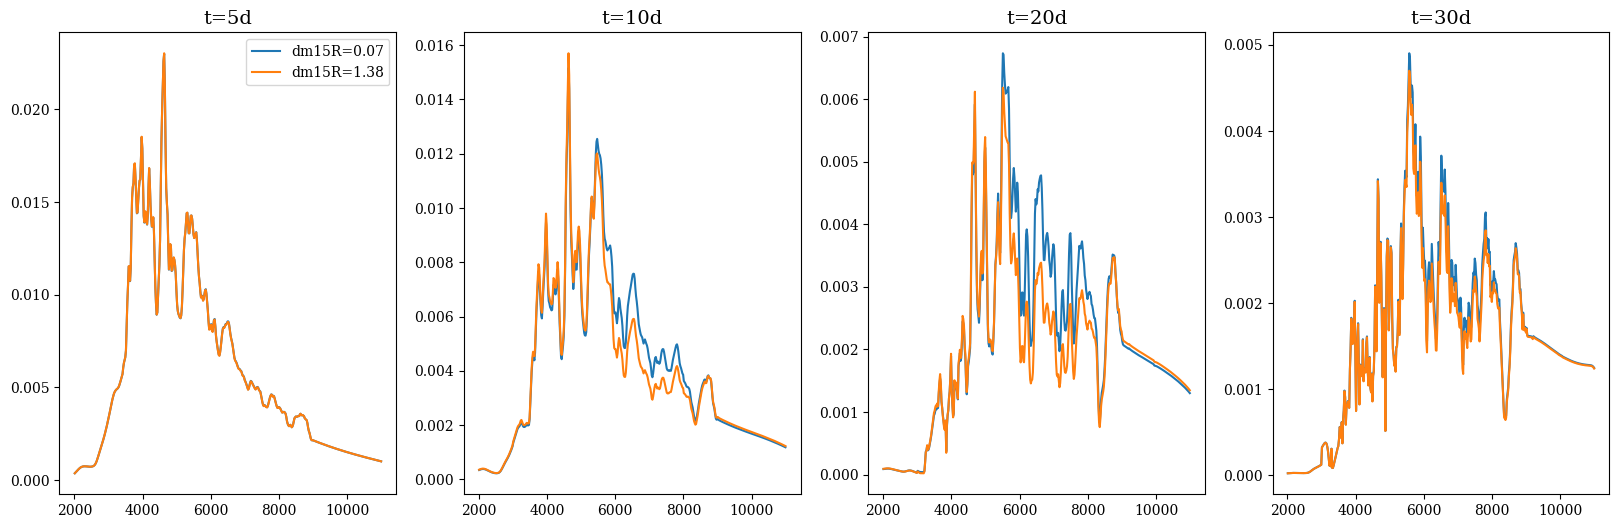

In [150]:
M_V = np.mean(infotbl['M_V'])
t_rise = np.mean(infotbl['t_rise'])
dm15B = np.mean(infotbl['dm15B'])
# dm15R = np.mean(infotbl['dm15R'])

dm15R0 = np.min(infotbl['dm15R'])
dm15R1 = np.max(infotbl['dm15R'])

plt.figure(figsize=(20, 6))
for tt, t in enumerate([5, 10, 20, 30]):
	plt.subplot(1, 4, tt+1)

	new_data0 = np.array(
		[[M_V, t_rise, dm15B, dm15R0, t]]
		)
	#	Spectrum : wavelength & flux
	flam0 = rf.predict(new_data0)[0]

	new_data1 = np.array(
		[[M_V, t_rise, dm15B, dm15R1, t]]
		)
	flam1 = rf.predict(new_data1)[0]

	plt.plot(lamarr, flam0, label=f'dm15R={dm15R0:.2f}')
	plt.plot(lamarr, flam1, label=f'dm15R={dm15R1:.2f}')

	if tt == 0: plt.legend(fontsize=10)
	plt.title(f"t={t}d")

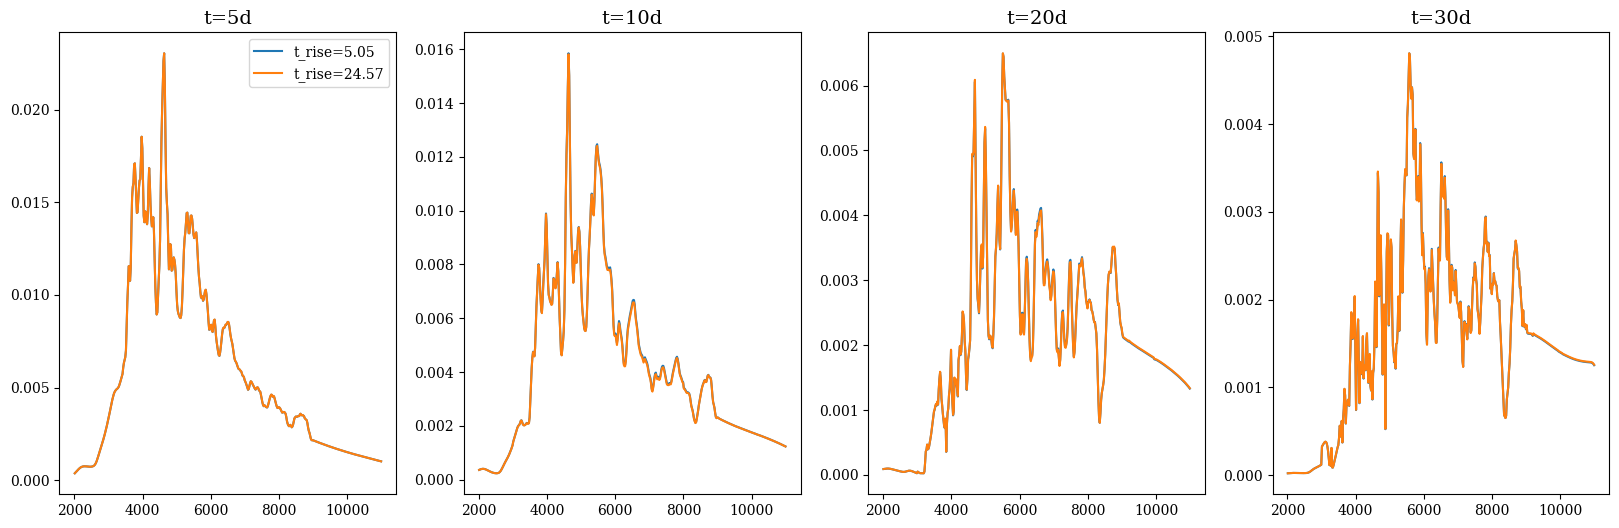

In [151]:
M_V = np.mean(infotbl['M_V'])
# t_rise = np.mean(infotbl['t_rise'])
dm15B = np.mean(infotbl['dm15B'])
dm15R = np.mean(infotbl['dm15R'])

t_rise0 = np.min(infotbl['t_rise'])
t_rise1 = np.max(infotbl['t_rise'])

plt.figure(figsize=(20, 6))
for tt, t in enumerate([5, 10, 20, 30]):
	plt.subplot(1, 4, tt+1)

	new_data0 = np.array(
		[[M_V, t_rise0, dm15B, dm15R, t]]
		)
	#	Spectrum : wavelength & flux
	flam0 = rf.predict(new_data0)[0]

	new_data1 = np.array(
		[[M_V, t_rise1, dm15B, dm15R, t]]
		)
	flam1 = rf.predict(new_data1)[0]

	plt.plot(lamarr, flam0, label=f't_rise={t_rise0:.2f}')
	plt.plot(lamarr, flam1, label=f't_rise={t_rise1:.2f}')

	if tt == 0: plt.legend(fontsize=10)
	plt.title(f"t={t}d")

# Fitting

In [6]:
register_custom_filters_on_speclite('../util')

# %%
intype = 'kn'
indist = 40
inexptime = 180
# group = 'broad_ugriz'
# group = input("""Choose the filterset (med25nm, broad_griz, broad_ugriz):""")
group = 'med25nm'
if group == 'med25nm':
	filterset_group = filterlist_med25nm
elif group == 'broad_griz':
	filterset_group = filterlist_griz
elif group == 'broad_ugriz':
	filterset_group = filterlist_ugriz
filterset = [f"{group}-{filte}" for filte, _, group in filterset_group]
bands = speclite.filters.load_filters(*filterset)

if 'med' in bands.names[0]:
	#    Medium-band
	bandwidth = 250 # [AA]
	lammin = 3000
	lammax = 10000
else:
	#	Broad-band
	bandwidth = 1000 # [AA]
	lammin = 2000
	lammax = 12000

lamstep = bandwidth/10
# lamarr = np.arange(lammin, lammax+lamstep, lamstep)
# _lamarr = np.arange(lammin, lammax+lamstep, 10)

print(f"lam: {lammin:.3f} - {lammax:.3f} AA")
print(f"lamstep: {lamstep:g} AA")
print(f"n_lam: {len(lamarr)}")

Use `med25nm`, `med50nm`, `broad` as `group_name`
lam: 3000.000 - 10000.000 AA
lamstep: 25 AA
n_lam: 450


In [109]:
if group == 'med25nm':
	#	Medium-band
	path_input = f'../input/{intype}/{indist:0>3}Mpc/{inexptime:0>3}s/{group}'
else:
	#	Broad-band
	path_input = f'../input/{intype}/{indist:0>3}Mpc/{inexptime:0>3}s/broad'
path_output = f'../fit_result/{intype}2{fittype}/{indist:0>3}Mpc/{inexptime:0>3}s/{group}'
if not os.path.exists(path_output):
	os.makedirs(path_output)
outfits = f"{path_output}/fit_result.fits"

# %%
intablelist = sorted(glob.glob(f"{path_input}/obs.*.fits"))
print(f"{len(intablelist)} input tables found")

# %%
outbl = Table()
#	Input data
outbl['input_table'] = [os.path.basename(intable) for intable in intablelist]
#	Detection / Fit
outbl['ndet'] = 0
outbl['det_filters'] = " "*200
outbl['det'] = False
outbl['fit'] = False
#	Fitted Parameters
outbl['z'] = 0.
outbl['t'] = 0.
for key in param_keys:
	outbl[key] = 0.
#	Error
outbl['zerr'] = 0.
outbl['terr'] = 0.
for key in param_keys:
	outbl[f"{key}err"] = 0.

#	Fit Results
outbl['free_params'] = 0
outbl['dof'] = 0
outbl['chisq'] = 0.
outbl['chisqdof'] = 0.
outbl['bic'] = 0.
#	Meta
outbl.meta['fittype'] = fittype
outbl.meta['source'] = source
outbl.meta['intype'] = intype
outbl.meta['indist[Mpc]'] = indist
outbl.meta['inexptime[s]'] = inexptime
outbl.meta['group'] = group
outbl.meta['date'] = Time.now().isot

# %%
#	Temp Table
_mdtbl = Table.read(intablelist[0])
for key, val in _mdtbl.meta.items():
	if key in ['MD', 'VD', 'MW', 'VW', 'ANG', 'PHASE', 'REDSHIFT',]:
		if type(val) is str:
			outbl[key] = ' '*10
		elif type(val) is float:
			outbl[key] = 0.0
		elif type(val) is int:
			outbl[key] = 0

# %%
def func(x, z, t, M_V, t_rise, dm15B, dm15R):

	new_data = np.array(
		[[M_V, t_rise, dm15B, dm15R, t]]
		)

	#	Spectrum : wavelength & flux
	flam = rf.predict(new_data)[0]

	#	Redshifted
	(zspappflam, zsplam) = apply_redshift_on_spectrum(flam*flamunit, lamarr*lamunit, z, z0=0)
	mags = bands.get_ab_magnitudes(*bands.pad_spectrum(zspappflam, zsplam))

	spmag = np.array([mags[key][0] for key in mags.keys()])
	spfnu = (spmag*u.ABmag).to(u.uJy).value

	return spfnu

# def func_norm(x, nt, nM_V, nt_rise, ndm15B, ndm15R, nz):
def _func_norm(x, nz, nt, nM_V, nt_rise, ndm15B, ndm15R):

	z = denormalize(nz, zarr)
	t = denormalize(nt, phasearr)
	M_V = denormalize(nM_V, infotbl['M_V'])
	t_rise = denormalize(nt_rise, infotbl['t_rise'])
	dm15B = denormalize(ndm15B, infotbl['dm15B'])
	dm15R = denormalize(ndm15R, infotbl['dm15R'])
	# print(z, t, M_V, t_rise, dm15B, dm15R)
	print(f"z={z:.9f} t={t:.9f} M_V={M_V:.9f} t_rise={t_rise:.9f} dm15B={dm15B:.9f} dm15R={dm15R:.9f}")
	# print(f"z={z:.3f} t={t:.3f} M_V={M_V:.3f} t_rise={t_rise:.3f} dm15B={dm15B:.3f} dm15R={dm15R:.3f}")

	new_data = np.array(
		[[M_V, t_rise, dm15B, dm15R, t]]
		)

	#	Spectrum : wavelength & flux
	flam = rf.predict(new_data)[0]

	#	Redshifted
	(zspappflam, zsplam) = apply_redshift_on_spectrum(flam*flamunit, lamarr*lamunit, z, z0=0)
	mags = bands.get_ab_magnitudes(*bands.pad_spectrum(zspappflam, zsplam))

	spmag = np.array([mags[key][0] for key in mags.keys()])
	spfnu = (spmag*u.ABmag).to(u.uJy).value

	return spfnu


def func_norm(x, nd, nt, nM_V, nt_rise, ndm15B, ndm15R):

	d = denormalize(nd, distarr)
	t = denormalize(nt, phasearr)
	M_V = denormalize(nM_V, infotbl['M_V'])
	t_rise = denormalize(nt_rise, infotbl['t_rise'])
	dm15B = denormalize(ndm15B, infotbl['dm15B'])
	dm15R = denormalize(ndm15R, infotbl['dm15R'])
	# print(z, t, M_V, t_rise, dm15B, dm15R)
	print(f"d={d:.9f} t={t:.9f} M_V={M_V:.9f} t_rise={t_rise:.9f} dm15B={dm15B:.9f} dm15R={dm15R:.9f}")
	# print(f"z={z:.9f} t={t:.9f} M_V={M_V:.9f} t_rise={t_rise:.9f} dm15B={dm15B:.9f} dm15R={dm15R:.9f}")
	# print(f"z={z:.3f} t={t:.3f} M_V={M_V:.3f} t_rise={t_rise:.3f} dm15B={dm15B:.3f} dm15R={dm15R:.3f}")

	# new_data = np.array(
	# 	[[M_V, t_rise, dm15B, dm15R, t]]
	# 	)

	#	Spectrum : wavelength & flux
	# flam = rf.predict(new_data)[0]
	flam = rf.predict(np.array([[M_V, t_rise, dm15B, dm15R, t]]))[0]

    # z = cosmology.dl_to_z(d*u.Mpc, cosmo=cosmo)
	z = z_at_value(cosmo.luminosity_distance, d*u.Mpc).value

	#	Redshifted
	(zspappflam, zsplam) = apply_redshift_on_spectrum(flam*flamunit, lamarr*lamunit, z, z0=0)
	mags = bands.get_ab_magnitudes(*bands.pad_spectrum(zspappflam, zsplam))

	spmag = np.array([mags[key][0] for key in mags.keys()])
	spfnu = (spmag*u.ABmag).to(u.uJy).value

	return spfnu



3600 input tables found


In [12]:

# %%
ii = 10
# ii = 20
intable = intablelist[ii]
st = time.time()

# %%
inexptime = 600


# %%
if group == 'med25nm':
	#	Medium-band
	path_input = f'../input/{intype}/{indist:0>3}Mpc/{inexptime:0>3}s/{group}'
else:
	#	Broad-band
	path_input = f'../input/{intype}/{indist:0>3}Mpc/{inexptime:0>3}s/broad'
path_output = f'../fit_result/{intype}2{fittype}/{indist:0>3}Mpc/{inexptime:0>3}s/{group}'
if not os.path.exists(path_output):
	os.makedirs(path_output)
outfits = f"{path_output}/fit_result.fits"

# %%
intablelist = sorted(glob.glob(f"{path_input}/obs.*.fits"))


print(f"{os.path.basename(intable)} ({inexptime}s) --> {fittype}")
intbl = Table.read(intable)


obs.000010.fits (600s) --> SNIax


In [13]:

# %%
indx_det = np.where(intbl['snr']>snrcut)
filterlist_det = list(intbl['filter'][indx_det])
filterlist_str = ",".join(filterlist_det)

# %%
filterset = [f"{group}-{filte}" for filte, _, group in filterset_group if filte in filterlist_det]
bands = speclite.filters.load_filters(*filterset)

# %%
# %%
ndet = len(filterset)
detection = np.any(intbl['snr'] > 5)
if verbose:
	print(f"number of detections: {ndet}")
	print(f"detection: {detection}")

# %%
xdata = intbl['fnuobs'].data[indx_det]
ydata = xdata
sigma = intbl['fnuerr'].data[indx_det]

# %% [markdown]
# - x, z, t, M_V, t_rise, dm15B, dm15R



number of detections: 20
detection: True


In [110]:
#	Normalization ver
#	Initial Guess
#	Redshift
p0list = [normalize_minmax(0.01, zarr), normalize_minmax(5, phasearr)]
#	Distance
p0list = [normalize_minmax(100, distarr), normalize_minmax(5, phasearr)]
# p0list = [normalize_minmax(5, phasearr)]
for key in param_keys:
	p0list.append(normalize_minmax(np.mean(infotbl[key]), infotbl[key]))
# p0list.append(normalize_minmax(0.01, zarr))
p0 = tuple(p0list)

#	Boundaries
loboundlist = [0.0]*(2+len(param_keys))
upboundlist = [1.0]*(2+len(param_keys))
# loboundlist = [normalize_minmax(0.02, zarr)]+[0.0]*(1+len(param_keys))
# upboundlist = [normalize_minmax(0.04, zarr)]+[1.0]*(1+len(param_keys))

bounds = (
	tuple(loboundlist),
	tuple(upboundlist),
)
n_free_param = len(inspect.signature(func).parameters)-1

# %%
popt, pcov = curve_fit(
	func_norm,
	xdata=xdata,
	ydata=ydata,
	sigma=sigma,
	p0=p0,
	absolute_sigma=True,
	check_finite=True,
	bounds=bounds,
	#	Method
	# method='dogbox',
	method='trf',
	# method='lm',
	#	Other option
	# max_nfev=1e4,
	# ftol=1e-15,
	# xtol=1e-15,
	# jac='3-point',
	# verbose=2,
	x_scale=np.array([5]*len(p0)),
)
fit = True


# %%
if fit:
	#	Fitting result
	r = ydata.data - func(xdata, *popt)
	n_free_param = len(inspect.signature(func).parameters)-1
	dof = ndet - n_free_param
	chisq_i = (r / sigma) ** 2
	chisq = np.sum(chisq_i)
	chisqdof = chisq/dof
	bic = chisq + n_free_param*np.log(ndet)
	perr = np.sqrt(np.diag(pcov))

	# %%
	z = denormalize(popt[0], zarr)
	t = denormalize(popt[1], phasearr)
	M_V = denormalize(popt[2], infotbl['M_V'])
	t_rise = denormalize(popt[3], infotbl['t_rise'])
	dm15B = denormalize(popt[4], infotbl['dm15B'])
	dm15R = denormalize(popt[5], infotbl['dm15R'])
	# z = denormalize(popt[-1], zarr)
	# t = denormalize(popt[0], phasearr)
	# M_V = denormalize(popt[1], infotbl['M_V'])
	# t_rise = denormalize(popt[2], infotbl['t_rise'])
	# dm15B = denormalize(popt[3], infotbl['dm15B'])
	# dm15R = denormalize(popt[4], infotbl['dm15R'])
	if verbose:
		# print(f"z={z:.3}")
		print(f"z={z:.3}")
		print(f"t={t:.3}")
		print(f"M_V={M_V:.3}")
		print(f"t_rise={t_rise:.3}")
		print(f"dm15B={dm15B:.3}")
		print(f"dm15R={dm15R:.3}")

	# %%
	outpng = f"{path_output}/{os.path.basename(intable).replace('obs', 'fit').replace('fits', 'png')}"

d=100.000000000 t=5.000000000 M_V=-15.901747253 t_rise=13.472989011 dm15B=1.714542458 dm15R=0.704589411
d=100.000014901 t=5.000000000 M_V=-15.901747253 t_rise=13.472989011 dm15B=1.714542458 dm15R=0.704589411
d=100.000000000 t=5.000000820 M_V=-15.901747253 t_rise=13.472989011 dm15B=1.714542458 dm15R=0.704589411
d=100.000000000 t=5.000000000 M_V=-15.901747143 t_rise=13.472989011 dm15B=1.714542458 dm15R=0.704589411
d=100.000000000 t=5.000000000 M_V=-15.901747253 t_rise=13.472989302 dm15B=1.714542458 dm15R=0.704589411
d=100.000000000 t=5.000000000 M_V=-15.901747253 t_rise=13.472989011 dm15B=1.714542488 dm15R=0.704589411
d=100.000000000 t=5.000000000 M_V=-15.901747253 t_rise=13.472989011 dm15B=1.714542458 dm15R=0.704589430
d=569.653211606 t=5.000000000 M_V=-15.901747253 t_rise=13.472989011 dm15B=1.714542458 dm15R=0.704589411
d=569.653226507 t=5.000000000 M_V=-15.901747253 t_rise=13.472989011 dm15B=1.714542458 dm15R=0.704589411
d=569.653211606 t=5.000000820 M_V=-15.901747253 t_rise=13.472989

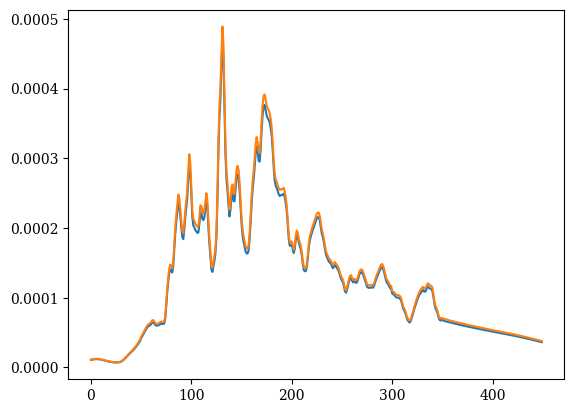

In [127]:
new_data0 = np.array(
	[[M_V, t_rise, dm15B, dm15R, 10]]
	)
#	Spectrum : wavelength & flux
flam0 = rf.predict(new_data0)[0]

new_data1 = np.array(
	[[M_V, t_rise, dm15B, dm15R, 10]]
	)
flam1 = rf.predict(new_data1)[0]

plt.plot(flam0)
plt.plot(flam1)

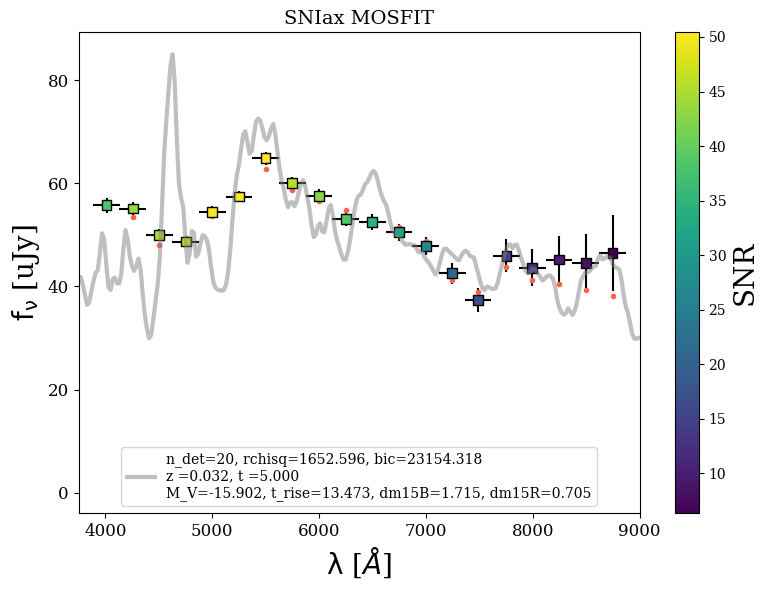

In [53]:

# %%
new_data = np.array(
	[[M_V, t_rise, dm15B, dm15R, t]]
	)

#	Spectrum : wavelength & flux
flam = rf.predict(new_data)[0]

# %%
(zspappflam, zsplam) = apply_redshift_on_spectrum(flam*flamunit, lamarr*lamunit, z, z0=0)
mags = bands.get_ab_magnitudes(*bands.pad_spectrum(zspappflam, zsplam))


spmag = np.array([mags[key][0] for key in mags.keys()])
spfnu = (spmag*u.ABmag).to(u.uJy).value

# %%
fnuarr = convert_flam2fnu(zspappflam, zsplam).to(u.uJy)

# %%
label = f"""n_det={ndet}, rchisq={chisqdof:.3f}, bic={bic:.3f}
z ={z:.3f}, t ={t:.3f}
M_V={M_V:.3f}, t_rise={t_rise:.3f}, dm15B={dm15B:.3f}, dm15R={dm15R:.3f}"""

# %%
plt.close('all')
plt.figure(figsize=(8, 6))
plt.plot(lamarr, fnuarr, c='grey', lw=3, alpha=0.5, label=label)
yl, yu = plt.ylim()
# plt.scatter(bands.effective_wavelengths, xdata, c=intbl['snr'], marker='s', s=50, ec='k')
plt.scatter(intbl['lam'], intbl['fnuobs'], c=intbl['snr'], marker='s', s=50, ec='k')
if 'med' in group:
	plt.errorbar(intbl['lam'], intbl['fnuobs'], xerr=bandwidth/2, yerr=intbl['fnuerr'], c='k', ls='none', zorder=0)
elif 'broad' in group:
	# plt.errorbar(intbl['lam'], intbl['fnuobs'], xerr=bandwidtharr_broad[indx_det]/2, yerr=intbl['fnuerr'], c='k', ls='none', zorder=0)					
	plt.errorbar(intbl['lam'], intbl['fnuobs'], xerr=bandwidtharr_broad/2, yerr=intbl['fnuerr'], c='k', ls='none', zorder=0)					
cbar = plt.colorbar()
cbar.set_label("SNR")
# plt.plot(bands.effective_wavelengths, func(xdata, *popt), '.', c='tomato')
plt.plot(intbl['lam'], intbl['fnu'], c='tomato', marker='.', ls='none', zorder=0)
plt.title(f"{fittype} {source.upper()}")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
if 'med' in group:
	xl = 3750
	xr = 9000
else:
	xl = 3000
	xr = 10000
plt.xlim([xl, xr])
plt.ylim([yl, yu])
plt.xlabel(r"$\rm \lambda$ [$\AA$]")
plt.ylabel(r"$\rm f_\nu$ [uJy]")
plt.legend(loc='lower center')
plt.tight_layout()